In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from importlib import reload
import json
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

import MultiLearn_GLRM

In [3]:
df = pd.read_csv('./prostate/prostate.data', delimiter='\t', index_col=0)
df = df.sample(frac=1).reset_index(drop=True)

mask_train = df.pop('train')
df_y = df.pop('lpsa')

X_train = df[mask_train == 'T']
Y_train = df_y[mask_train == 'T']
Y_train = np.array(Y_train).reshape(-1,1)


X_test = df[mask_train != 'T']
Y_test = df_y[mask_train != 'T']
Y_test = np.array(Y_test).reshape(-1,1)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


scaler2 = StandardScaler()
Y_train = scaler2.fit_transform(Y_train)
Y_test = scaler2.transform(Y_test)

params = {
    "train_hyper_params": None,
    "test_hyper_params": None,
    "beta": None,
    "embedding_matrix": None,
    "train_error": None,
    "test_error": None,
    "embedding_dim": None,
    "predictor_scaling_parmas": None,
    "target_scaling_parmas": None
}

In [5]:
params["predictor_scaling_parmas"] =  {
    "mean" : scaler.mean_.tolist(),
    "var" : scaler.mean_.tolist()
}
params["target_scaling_parmas"] =  {
    "mean" : scaler2.mean_.tolist(),
    "var" : scaler2.mean_.tolist()
}

In [31]:
reload(MultiLearn_GLRM)
from MultiLearn_GLRM import Multi_Learn, generate_AXY
from MultiLearn_GLRM.Params.semisupervised_params import Multilearn_GLRM_Semisupervised_Train_Params, Multilearn_GLRM_Semisupervised_Test_Params

embedding_dim = 2
params["embedding_dim"] = embedding_dim

n_class = 1

A_prime, X_prime, Y_prime = generate_AXY.get_semisupervised_glrm_train_form(X_train, Y_train, n_class, embedding_dim)
GLRM_loss_list, X_regulariation_list, Y_regulariation_list, X_grad_restrictions, Y_grad_restrictions = Multilearn_GLRM_Semisupervised_Train_Params(A_prime, X_prime, Y_prime, n_class)

params["train_hyper_params"] = [GLRM_loss_list, X_regulariation_list, Y_regulariation_list]

num_iterations=100
learning_rate=0.01
result = Multi_Learn.alternating_minimization(A_prime, X_prime, Y_prime, GLRM_loss_list, X_regulariation_list, Y_regulariation_list, X_grad_restrictions, Y_grad_restrictions, num_iterations, learning_rate, n_class)



epoch: 0
iter: 1 Total loss: tf.Tensor(15.157276489130181, shape=(), dtype=float64) [14.739925699040601, 3.3841707336674105]
iter: 100 Total loss: tf.Tensor(6.946555546196082, shape=(), dtype=float64) [6.487195886857636, 3.7767666278947907]
iter: 1 Total loss: tf.Tensor(6.892087544636837, shape=(), dtype=float64)
iter: 100 Total loss: tf.Tensor(1.1723528869581243, shape=(), dtype=float64)
epoch: 1
iter: 1 Total loss: tf.Tensor(1.1701237103788271, shape=(), dtype=float64) [0.7181032832890423, 0.8386316733224963]
iter: 100 Total loss: tf.Tensor(0.8964076120267905, shape=(), dtype=float64) [0.5423576726772364, 0.7908686992236242]
iter: 1 Total loss: tf.Tensor(0.8952778836763631, shape=(), dtype=float64)
iter: 31 Total loss: tf.Tensor(0.8026794823307477, shape=(), dtype=float64)
epoch: 2
iter: 1 Total loss: tf.Tensor(0.8023125956271115, shape=(), dtype=float64) [0.3388963341918136, 0.7442750162877194]
iter: 100 Total loss: tf.Tensor(0.6715363535748888, shape=(), dtype=float64) [0.388608519

In [32]:
beta = result[1][1:,0:n_class]
Y_final = result[1][1:embedding_dim+1,n_class:]
params["beta"] = beta.numpy().tolist()
params["embedding_matrix"] = Y_final.numpy().tolist()


res = np.matmul(result[0], result[1][:,0:n_class])
params["train_error"] = np.mean((scaler2.inverse_transform(Y_train) - scaler2.inverse_transform(res))**2)
params["train_error"]

0.3682432675186439

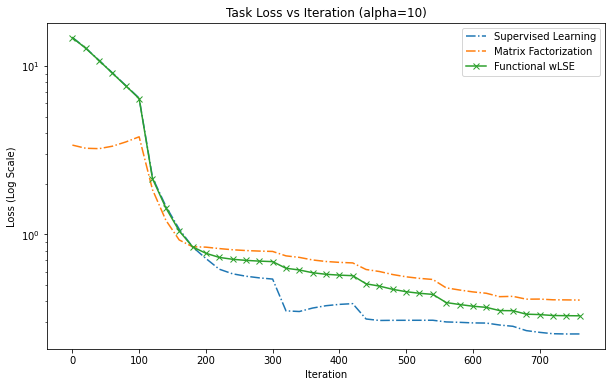

In [37]:
plt.figure(figsize=(10, 6))
x_values = list(range(0, len(result[-1]['SupervisedEmbeddings'])))

plt.plot(x_values[::20], result[-1]['SupervisedEmbeddings'][::20],'-.', label="Supervised Learning")
plt.plot(x_values[::20], result[-1]['Factorization'][::20], '-.', label="Matrix Factorization")
plt.plot(x_values[::20], result[-1]['WLSE'][::20],'-x', label="Functional wLSE")
plt.yscale('log')
# plt.xticks( x_values[::20])
plt.ylabel('Loss (Log Scale)')
plt.xlabel('Iteration')
plt.title('Task Loss vs Iteration (alpha=10)')
plt.legend()
plt.savefig('./prostate/plots/prostate_loss_vs_iteration_alpha_10')

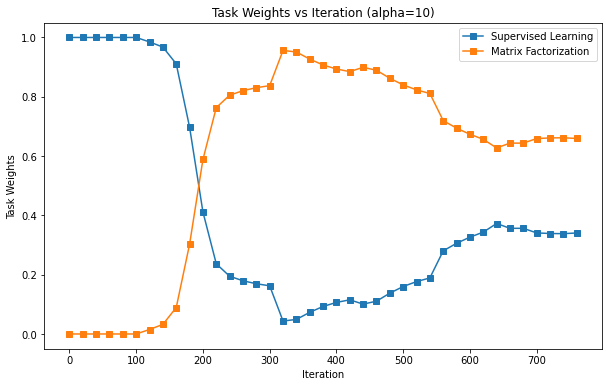

In [36]:
alpha = 10
w1 = 0.7
w2= 0.3

SupervisedEmbeddings_weights = w1*np.exp(alpha*np.array(result[-1]['SupervisedEmbeddings']))
Factorization_weights = w2*np.exp(alpha*np.array(result[-1]['Factorization']))
SupervisedEmbeddings_weights_normalized = SupervisedEmbeddings_weights/(SupervisedEmbeddings_weights+Factorization_weights)
Factorization_weights_normalized = Factorization_weights/(SupervisedEmbeddings_weights+Factorization_weights)

plt.figure(figsize=(10, 6))
x_values = list(range(0, len(result[-1]['SupervisedEmbeddings'])))

plt.plot(x_values[::20], SupervisedEmbeddings_weights_normalized[::20],'-s', label="Supervised Learning")
plt.plot(x_values[::20], Factorization_weights_normalized[::20], '-s', label="Matrix Factorization")

# plt.xticks( x_values[::20])
plt.ylabel('Task Weights')
plt.xlabel('Iteration')
plt.title('Task Weights vs Iteration (alpha=10)')
plt.legend()

plt.savefig('./prostate/plots/prostate_task_weight_vs_iteration_alpha_10')



In [85]:
# res = np.matmul(result[0], result[1][:,0:n_class])
# np.mean((Y_train - res)**2)
# 0.4495674496068231

# res = np.matmul(result[0], result[1][:,0:n_class])
# np.mean((Y_train - res)**2)
# 0.4011543372347976


0.4495674496068231

In [171]:
beta

<tf.Tensor: shape=(11, 1), dtype=float64, numpy=
array([[-0.54822265],
       [ 0.18504926],
       [ 0.53468388],
       [ 0.10875677],
       [-0.15328889],
       [ 0.04023021],
       [ 0.32229294],
       [-0.09989735],
       [ 0.11034852],
       [ 0.20666993],
       [-0.00857186]])>

In [ ]:
"""
<tf.Tensor: shape=(11, 1), dtype=float64, numpy=
array([[-0.02956712],
       [-0.43500185],
       [ 0.46663761],
       [ 0.28479513],
       [-0.04591487],
       [ 0.22732162],
       [ 0.19878154],
       [-0.21300145],
       [ 0.0071286 ],
       [ 0.11102323],
       [-0.00936144]])>
"""

In [128]:
for i in range(0, Y_train.shape[0]):
    print(Y_train[i], res[i])

[-0.74593503] [-0.96229798]
[-0.54413252] [-0.3064417]
[0.42572773] [0.49896302]
[-0.12910999] [-0.22557737]
[-0.14604851] [-0.50146602]
[-0.33755776] [-0.96446617]
[-0.10433023] [-0.2433947]
[0.22160766] [0.39486495]
[-0.46525248] [-0.36193532]
[1.28570526] [0.79757593]
[0.88730351] [-0.11278371]
[-0.92117503] [-0.60090279]
[1.05108772] [0.47456888]
[0.29533824] [-0.06985816]
[-1.33298049] [-0.40549443]
[-0.98884928] [-1.13738764]
[0.94708489] [0.26740704]
[0.73842883] [0.83253999]
[-0.98884928] [-0.8239089]
[0.18789838] [0.47127532]
[-0.24590799] [-0.5295947]
[0.17051873] [0.06774572]
[0.98321259] [1.01878964]
[0.89960743] [0.40834803]
[-0.61609027] [-0.16480375]
[-0.19903089] [0.92132432]
[-0.83871855] [-0.54230546]
[-0.21746688] [-1.1389276]
[-0.50376054] [-0.26556439]
[1.39911185] [1.27266157]
[-0.37049067] [-0.32148454]
[-0.6312578] [-1.04501508]
[0.48800976] [-0.0971723]
[0.09713585] [1.16140715]
[-0.67848884] [-0.63232126]
[0.28519596] [-0.04114821]
[0.33471745] [0.39521395]
[0

In [35]:
reload(MultiLearn_GLRM)
from MultiLearn_GLRM import Multi_Learn, generate_AXY
from MultiLearn_GLRM.Params.semisupervised_params import Multilearn_GLRM_Semisupervised_Train_Params, Multilearn_GLRM_Semisupervised_Test_Params

A = X_test
A_prime =tf.constant(A)


X = np.random.standard_normal((A.shape[0], embedding_dim))
X_prime = X
X_prime = tf.Variable(X_prime)

Y_prime = Y_final

GLRM_loss_list, X_regularization_loss_list, Y_regularization_loss_list, X_grad_restrictions, Y_grad_restrictions =  Multilearn_GLRM_Semisupervised_Test_Params(A_prime, X_prime, Y_prime)
params["test_hyper_params"] = [GLRM_loss_list, X_regularization_loss_list, Y_regularization_loss_list]

num_iterations=10000
learning_rate=0.01
results_log = []
for i in range(0,10):
    A = X_test
    A_prime =tf.constant(A)


    X = np.random.uniform(-1,1, (A.shape[0], embedding_dim))
    X_prime = X
    X_prime = tf.Variable(X_prime)

    Y_prime = Y_final

    result_val = Multi_Learn.predict(A_prime, X_prime, Y_prime, GLRM_loss_list, X_regularization_loss_list, Y_regularization_loss_list, num_iterations, learning_rate)
    val_pred = np.hstack((result_val[0], A_prime))
    val_pred = np.hstack((val_pred, np.ones(shape=(val_pred.shape[0],1))))
    regress_val = np.matmul(val_pred, beta)
    print(np.mean((scaler2.inverse_transform(Y_test) - scaler2.inverse_transform(regress_val))**2))
    results_log.append(np.mean((scaler2.inverse_transform(Y_test) - scaler2.inverse_transform(regress_val))**2))

params["test_error"] = results_log

# with open('./logs/Prostate_'+ str(round(np.mean(results_log),5))+'_MSE.json', 'w') as f:
#     f.write(json.dumps(params, sort_keys=True, indent=4, separators=(',', ': ')))




iter: 1 Total loss: tf.Tensor(1.846975195935874, shape=(), dtype=float64)
iter: 100 Total loss: tf.Tensor(0.47256795905456694, shape=(), dtype=float64)
iter: 199 Total loss: tf.Tensor(0.3756464618835362, shape=(), dtype=float64)
iter: 277 Total loss: tf.Tensor(0.3716629719204157, shape=(), dtype=float64)
0.4896981954283165
iter: 1 Total loss: tf.Tensor(1.850371874575392, shape=(), dtype=float64)
iter: 100 Total loss: tf.Tensor(0.4794582721888735, shape=(), dtype=float64)
iter: 199 Total loss: tf.Tensor(0.3771997718239145, shape=(), dtype=float64)
iter: 291 Total loss: tf.Tensor(0.3716903223389, shape=(), dtype=float64)
0.4910819270749502
iter: 1 Total loss: tf.Tensor(1.8665227166070286, shape=(), dtype=float64)
iter: 100 Total loss: tf.Tensor(0.5422590780407172, shape=(), dtype=float64)
iter: 199 Total loss: tf.Tensor(0.3904372084705908, shape=(), dtype=float64)
iter: 298 Total loss: tf.Tensor(0.37329431022757326, shape=(), dtype=float64)
iter: 360 Total loss: tf.Tensor(0.3718075015544

In [157]:
params

{'train_hyper_params': [[{'Description': 'Supervised Learning Matrix Location',
    'A_start_row': 0,
    'A_end_row': 67,
    'A_start_col': 0,
    'A_end_col': 1,
    'X_start_row': 0,
    'X_end_row': 67,
    'X_start_col': 1,
    'X_end_col': 12,
    'Y_start_row': 1,
    'Y_end_row': 12,
    'Y_start_col': 0,
    'Y_end_col': 1,
    'loss': 'MSE',
    'weight': 0.7,
    'alpha': 5},
   {'Description': 'Matrix Factorization Matrix Location',
    'A_start_row': 0,
    'A_end_row': 67,
    'A_start_col': 1,
    'A_end_col': 9,
    'X_start_row': 0,
    'X_end_row': 67,
    'X_start_col': 1,
    'X_end_col': 3,
    'Y_start_row': 1,
    'Y_end_row': 3,
    'Y_start_col': 1,
    'Y_end_col': 9,
    'weight': 0.3,
    'alpha': 5,
    'loss': 'MSE'}],
  [{'Description': 'Regularize first column of X (constant 0)',
    'X_start_row': 0,
    'X_end_row': 67,
    'X_start_col': 0,
    'X_end_col': 1,
    'penalty_type': 'inf',
    'alpha': 99999999999.9},
   {'Description': 'Regularize cons

In [154]:
val_pred = np.hstack((result_val[0], A_prime))
val_pred = np.hstack((val_pred, np.ones(shape=(val_pred.shape[0],1))))
regress_val = np.matmul(val_pred, beta)
np.mean((scaler2.inverse_transform(Y_test) - scaler2.inverse_transform(regress_val))**2)

0.4496471293720549

In [38]:
regress_val

array([[ 2.30923451],
       [ 0.50613568],
       [-0.8628483 ],
       [ 0.74312623],
       [ 0.20962183],
       [-0.55266391],
       [-3.50156826],
       [-2.65497436],
       [-0.57342551],
       [-2.41594279],
       [-0.13582648],
       [ 1.65054362],
       [-1.98419775],
       [ 0.55293849],
       [-1.65754598],
       [-0.78133466],
       [-0.93538785],
       [-0.73470754],
       [ 1.15636356],
       [ 0.0607335 ],
       [-2.04546397],
       [ 1.63477858],
       [-1.20399331],
       [ 0.08267352],
       [ 0.02493476],
       [-2.00865144],
       [-1.57173321],
       [ 1.12387255],
       [-1.2316063 ],
       [ 1.66820273]])

In [41]:
Y_train

array([[ 3.3375474],
       [ 1.6956156],
       [ 1.446919 ],
       [ 1.4701758],
       [ 2.8535925],
       [ 2.7942279],
       [ 1.2669476],
       [ 4.029806 ],
       [ 3.0130809],
       [ 3.5307626],
       [ 2.9204698],
       [ 2.1575593],
       [ 2.2137539],
       [ 2.2975726],
       [ 1.4929041],
       [-0.1625189],
       [ 3.5652984],
       [ 2.0476928],
       [ 1.5993876],
       [ 2.5533438],
       [ 3.4355988],
       [ 2.8124102],
       [ 2.5217206],
       [-0.4307829],
       [ 1.8484548],
       [ 2.8419982],
       [ 4.3851468],
       [ 3.0373539],
       [ 4.1295508],
       [ 5.477509 ],
       [ 1.3480731],
       [ 2.677591 ],
       [ 3.3928291],
       [ 3.7123518],
       [ 3.5876769],
       [ 2.2772673],
       [-0.1625189],
       [ 2.5687881],
       [-0.1625189],
       [ 2.1916535],
       [ 1.9242487],
       [ 0.7654678],
       [ 0.8544153],
       [ 2.7180005],
       [ 1.6389967],
       [ 3.993603 ],
       [ 2.9626924],
       [ 1.71

In [216]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_test, predictions_val), confusion_matrix(Y_train, predictions)

(array([[4601,  133],
        [ 961,  305]]),
 array([[18416,   214],
        [ 3461,  1909]]))

In [204]:
409/(409+200), 409/(409+857)

(0.6715927750410509, 0.32306477093206953)

In [217]:
305/(305+133), 305/(305+961)

(0.6963470319634704, 0.24091627172195892)

In [205]:
2027/(2027+538), 2027/(2027+3343)

(0.7902534113060429, 0.37746741154562385)

In [206]:
from sklearn.linear_model import LogisticRegression

X_train_embedding = result[0][:, 1:embedding_dim+1]
X_train_embedding = X_train_embedding.numpy()

X_test_embedding = result_val[0].numpy()


clf = LogisticRegression().fit(X_train_embedding, Y_train)
pred_logistic = clf.predict(X_train_embedding)
pred_logistic_val = clf.predict(X_test_embedding)
accuracy_score(Y_train, pred_logistic), accuracy_score(Y_test, pred_logistic_val)

(0.814375, 0.8043333333333333)

In [208]:
confusion_matrix(Y_test, pred_logistic_val), confusion_matrix(Y_train, pred_logistic)

(array([[4498,  236],
        [ 938,  328]]),
 array([[17980,   650],
        [ 3805,  1565]]))

In [209]:
328/(328+236), 328/(328+938)

(0.5815602836879432, 0.25908372827804105)

In [210]:
1565/(1565+650), 1565/(1565+3805)

(0.7065462753950339, 0.2914338919925512)

In [183]:
beta[5:]

<tf.Tensor: shape=(24,), dtype=float64, numpy=
array([-0.06078221, -0.08096537,  0.07017905, -0.22062607,  0.35488053,
        0.39862827,  0.2153722 ,  0.06315138,  0.01180752,  0.06021941,
        0.04830898, -0.18859167,  0.08307187,  0.16422852,  0.00642617,
        0.14052606,  0.0896697 , -0.22232949, -0.17849683, -0.08283164,
       -0.11471487, -0.12704948, -0.07854479, -1.26667971])>

In [163]:
A_prime[0]

<tf.Tensor: shape=(23,), dtype=float64, numpy=
array([-0.8944437 , -1.29999224,  0.19562207,  0.8480684 , -1.33541679,
        1.78308844,  1.76876603,  0.12852902,  0.18145061,  0.22244805,
        0.24003907,  0.00893509,  0.01580282,  0.03063303,  0.02771253,
       -0.31078083, -0.31270152, -0.36732258, -0.16417763, -0.16869953,
       -0.18406823, -0.26715539, -0.25424832])>

In [ ]:
x_embeddings

In [62]:
prob_val[0:10]

array([0.34780297, 0.16671354, 0.16582201, 0.64219219, 0.1262042 ,
       0.20658415, 0.08178106, 0.15208459, 0.1876595 , 0.15627313])

In [63]:
prob[0:10]

array([0.34500034, 0.21897527, 0.21774101, 0.24583357, 0.30727848,
       0.22784088, 0.50308932, 0.13373273, 0.30618575, 0.07753649])

In [ ]:
temp = tf.Variable([1,1,1])
tf.where(temp!=1).shape[0]
# tf.where([True, False, False, True]).numpy()

In [151]:
np.min(val_pred,axis=0)

array([-1.9516478 , -2.04629543, -1.70377307, -2.15427262, -1.38936124,
       -1.20421852, -1.29999224, -2.36851212, -2.98284474, -1.55114657,
       -1.77752498, -1.56302776, -1.53258922, -1.53304331, -1.53661396,
       -1.48686073, -0.85538492, -1.65103594, -1.35636746, -1.70503041,
       -1.67992001, -4.18589619, -0.3678535 , -0.2796292 , -0.30874059,
       -0.31871886, -0.31325859, -0.29435041,  1.        ])

In [152]:
np.min(result[0],axis=0)

array([ 0.        , -2.11853932, -1.95478155, -2.32238873, -1.65901012,
       -1.37094107, -1.20421852, -1.29999224, -2.36851212, -2.98284474,
       -1.55114657, -1.77752498, -1.56302776, -1.53258922, -1.53304331,
       -1.53661396, -1.48686073, -2.97568136, -1.68302713, -2.986122  ,
       -3.36721611, -2.01072475, -6.39286167, -0.3678535 , -0.2796292 ,
       -0.30874059, -0.31871886, -0.31325859, -0.29435041,  1.        ])

In [153]:
beta

<tf.Tensor: shape=(29,), dtype=float64, numpy=
array([ 2.32920304,  1.87744885,  2.28603496,  0.0193024 ,  1.94286537,
       -0.05994122, -0.09603823, -0.12248185, -0.20116798,  0.17172587,
        0.24053478,  0.05275302, -0.00564511, -0.04167461,  0.09804698,
        0.02832339, -0.25440925,  0.18297612, -0.08606386, -0.02333948,
       -0.24518346,  0.50206154, -0.1084216 , -0.01720935, -0.23590036,
        0.28719348,  0.0371344 ,  0.08209635, -1.26288559])>

In [69]:
result[0][3:10,:]

<tf.Tensor: shape=(7, 29), dtype=float64, numpy=
array([[ 0.00000000e+00,  2.79704164e-02,  1.24598251e-01,
         8.08389672e-03, -1.64245262e-01, -8.94443705e-01,
         7.69235361e-01,  1.95622071e-01, -1.06738817e+00,
         1.74691685e-01,  2.78172924e-03,  1.02869133e-01,
         1.28529024e-01,  1.81450606e-01,  2.22448051e-01,
         2.40039073e-01, -4.96488771e-02, -5.87046225e-03,
         4.28777847e-02, -2.22836998e-01, -1.82979704e-01,
        -1.52426383e-01, -2.35124189e-01, -1.82546015e-01,
        -2.34184570e-01, -2.44808832e-01, -2.43252446e-01,
        -2.37628924e-01,  1.00000000e+00],
       [ 0.00000000e+00, -2.86595088e-02,  1.35622732e-01,
        -2.72350274e-01, -4.77846802e-01, -8.94443705e-01,
        -1.29999224e+00,  1.95622071e-01, -1.06738817e+00,
         2.33198950e+00, -8.87371627e-01,  1.02869133e-01,
        -7.02030096e-01,  1.81450606e-01,  2.22448051e-01,
         2.40039073e-01, -5.77854383e-01, -6.10775294e-01,
        -1.54446033e-01

In [103]:
'beta' in params.keys()

True